In [ ]:
from pathlib import Path

import geopandas
import matplotlib.pyplot as plt
import pandas
import snkit

from pyproj import Geod
from rasterstats import gen_zonal_stats
from snail_datapkg.spatial import polygonise_targets

In [2]:
# set up variables for incoming and processed data paths
project_path = Path().resolve().parent # assume we're running from the project scripts directory, so get the parent
incoming_data_path = project_path / "incoming_data"
processed_data_path = project_path / "processed_data"

In [3]:
# read in the power lines
lines_df = geopandas.read_file(incoming_data_path / "starter-data-kit/data/ZAF/gridfinder/grid__ZAF.gpkg")

In [4]:
# Assume openstreetmap source lines are high-voltage, and inferred lines are medium
source_to_voltage = {
    "openstreetmap": "high",
    "gridfinder": "medium"
}
lines_df['line_voltage_class'] = lines_df.source.map(source_to_voltage)
lines_df

,source,geometry,line_voltage_class
0,gridfinder,"LINESTRING (22.41458 -22.12708, 22.41875 -22.1...",medium
1,gridfinder,"LINESTRING (29.63125 -22.12708, 29.63958 -22.1...",medium
2,openstreetmap,"LINESTRING (31.89792 -22.12708, 31.90208 -22.1...",high
3,openstreetmap,"LINESTRING (31.90625 -22.12708, 31.90208 -22.1...",high
4,openstreetmap,"LINESTRING (31.90625 -22.12708, 31.91042 -22.1...",high
...,...,...,...
47105,gridfinder,"LINESTRING (20.22292 -34.66042, 20.21875 -34.6...",medium
47106,gridfinder,"LINESTRING (19.51042 -34.66458, 19.52292 -34.6...",medium
47107,openstreetmap,"LINESTRING (20.04792 -34.80625, 20.03958 -34.7...",high
47108,gridfinder,"LINESTRING (20.05625 -34.81042, 20.05208 -34.8...",medium


In [14]:
(processed_data_path / "networks").mkdir(exist_ok=True)
lines_df.to_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="lines")

In [5]:
power_df = pandas.read_excel(incoming_data_path / "global-energy-monitor" / "Global-Integrated-Power-March-2025.xlsx", sheet_name="Power facilities")

/home/mert2014/micromamba/envs/snail-datapkg/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
power_df.columns

Index(['Type', 'Country/area', 'Subregion', 'Region', 'Plant / Project name',
       'Unit / Phase name', 'Plant / Project name (local)',
       'Plant / Project name (other)', 'Capacity (MW)', 'Status', 'Start year',
       'Retired year', 'Technology', 'Fuel', 'Hydrogen production',
       'Hydrogen capable', 'Country/area 1 (hydropower only)',
       'Country/area 2 (hydropower only)',
       'Country/area 1 Capacity (MW) (hydropower only)',
       'Country/area 2 Capacity (MW) (hydropower only)', 'Owner', 'Parent',
       'CHP', 'CCS', 'Conversion/replacement', 'Unit conversion year',
       'Conversion from/replacement of (fuel)',
       'Conversion from/replacement of (GEM unit ID)', 'Captive Industry Type',
       'Captive Industry Use', 'Captive Non Industry Use', 'Latitude',
       'Longitude', 'Location accuracy', 'City', 'Local area (taluk, county)',
       'Major area (prefecture, district)',
       'Subnational unit (state, province)', 'GEM location ID',
       'GEM unit/p

In [7]:
to_rename = {
    'Type': 'generation_type',
    'Country/area': 'country',
    'Plant / Project name': 'name',
    'Capacity (MW)': 'capacity_mw',
    'Status': 'status',
    'Start year': 'start_year',
    'Technology': 'technology',
    'Latitude': 'lat',
    'Longitude': 'lng',
    'Location accuracy': 'location_accuracy',
    'City': 'city',
    'GEM location ID': 'gem_location_id',
    'GEM.Wiki URL': 'gem_wiki_url',
}
power_df = power_df.rename(columns=to_rename)[to_rename.values()].query("country == 'South Africa' and status == 'operating'")

geom = geopandas.points_from_xy(power_df.lng, power_df.lat, crs="EPSG:4326")
power_gdf = geopandas.GeoDataFrame(data=power_df, geometry=geom)
power_gdf

,generation_type,country,name,capacity_mw,status,start_year,technology,lat,lng,location_accuracy,city,gem_location_id,gem_wiki_url,geometry
3350,hydropower,South Africa,Drakensberg hydroelectric plant,1000.0,operating,1982,pumped storage,-28.5660,29.0834,exact,Okhahlamba Local Municipality,L603315,https://gem.wiki/Drakensberg_hydroelectric_plant,POINT (29.0834 -28.566)
3351,hydropower,South Africa,Gariep hydroelectric plant,360.0,operating,1971,conventional storage,-30.6233,25.5067,exact,Gariep Local Municipality,L603316,https://gem.wiki/Gariep_hydroelectric_plant,POINT (25.5067 -30.6233)
3352,hydropower,South Africa,Ingula hydroelectric plant,1332.0,operating,2016,pumped storage,-28.2809,29.5880,exact,Emnambithi/Ladysmith Local Municipality,L603317,https://gem.wiki/Ingula_hydroelectric_plant,POINT (29.588 -28.2809)
3353,hydropower,South Africa,Palmiet hydroelectric plant,400.0,operating,1988,pumped storage,-34.1985,18.9746,exact,Theewaterskloof Local Municipality,L603318,https://gem.wiki/Palmiet_hydroelectric_plant,POINT (18.9746 -34.1985)
3354,hydropower,South Africa,Steenbras hydroelectric plant,160.0,operating,1979,pumped storage,-34.1520,18.8982,exact,NaN,L603319,https://gem.wiki/Steenbras_hydroelectric_plant,POINT (18.8982 -34.152)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128216,solar,South Africa,Welkom Lejweleputswa District Municipality sol...,7.9,operating,2022,Assumed PV,-27.9220,26.6834,exact,Welkom,L100001021008,https://www.gem.wiki/Welkom_Lejweleputswa_Dist...,POINT (26.6834 -27.922)
128217,solar,South Africa,Welkom Lejweleputswa District Municipality sol...,10.8,operating,2023,Assumed PV,-27.9264,26.7080,exact,Welkom,L100001021009,https://www.gem.wiki/Welkom_Lejweleputswa_Dist...,POINT (26.708 -27.9264)
128218,solar,South Africa,Witzenberg Local Municipality Cape Winelands D...,6.3,operating,NaN,Assumed PV,-33.4324,19.2300,exact,Witzenberg Local Municipality,L100001020963,https://www.gem.wiki/Witzenberg_Local_Municipa...,POINT (19.23 -33.4324)
128219,solar,South Africa,Witzenberg Local Municipality Cape Winelands D...,2.0,operating,2020,Assumed PV,-33.2271,19.2364,exact,Witzenberg Local Municipality,L100001021004,https://www.gem.wiki/Witzenberg_Local_Municipa...,POINT (19.2364 -33.2271)


In [13]:
(processed_data_path / "networks").mkdir(exist_ok=True)
power_gdf.to_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="generation")

In [8]:
electrified_areas = polygonise_targets(incoming_data_path / "starter-data-kit/data/ZAF/gridfinder/targets__ZAF.tif")

In [9]:
electrified_areas

,area_km2,geometry,id
0,0.198346,"POLYGON ((17.25625 -22.11875, 17.25625 -22.122...",0
1,0.595037,"POLYGON ((26.91875 -22.11875, 26.91875 -22.122...",1
2,1.586707,"POLYGON ((22.40625 -22.11875, 22.40625 -22.122...",2
3,0.991674,"POLYGON ((29.62292 -22.12292, 29.62292 -22.135...",3
4,0.396651,"POLYGON ((22.41875 -22.13125, 22.41875 -22.139...",4
...,...,...,...
19280,1.588949,"POLYGON ((20.21042 -34.64792, 20.21042 -34.656...",19280
19281,0.353070,"POLYGON ((19.51458 -34.66042, 19.51458 -34.664...",19281
19282,2.291618,"POLYGON ((20.03125 -34.77292, 20.03125 -34.777...",19282
19283,3.172316,"POLYGON ((20.03958 -34.79792, 20.03958 -34.802...",19283


In [10]:
population_tif = incoming_data_path / "starter-data-kit/data/ZAF/jrc_ghsl/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0__ZAF.tif"
zone_pops = [
    p['sum']
    for p in gen_zonal_stats(
        electrified_areas.geometry,
        population_tif,
        stats=['sum']
    )
]
electrified_areas['population'] = zone_pops
electrified_areas

/home/mert2014/micromamba/envs/snail-datapkg/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,area_km2,geometry,id,population
0,0.198346,"POLYGON ((17.25625 -22.11875, 17.25625 -22.122...",0,NaN
1,0.595037,"POLYGON ((26.91875 -22.11875, 26.91875 -22.122...",1,62.929560
2,1.586707,"POLYGON ((22.40625 -22.11875, 22.40625 -22.122...",2,650.472893
3,0.991674,"POLYGON ((29.62292 -22.12292, 29.62292 -22.135...",3,130.910554
4,0.396651,"POLYGON ((22.41875 -22.13125, 22.41875 -22.139...",4,0.862991
...,...,...,...,...
19280,1.588949,"POLYGON ((20.21042 -34.64792, 20.21042 -34.656...",19280,164.832179
19281,0.353070,"POLYGON ((19.51458 -34.66042, 19.51458 -34.664...",19281,8.487362
19282,2.291618,"POLYGON ((20.03125 -34.77292, 20.03125 -34.777...",19282,2820.542945
19283,3.172316,"POLYGON ((20.03958 -34.79792, 20.03958 -34.802...",19283,680.932165


In [12]:
(processed_data_path / "networks").mkdir(exist_ok=True)
electrified_areas.to_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="targets")

## Network setup

In [30]:
lines = geopandas.read_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="lines")
targets = geopandas.read_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="targets")
generation = geopandas.read_file(processed_data_path / "networks/power.2025-05-01.gpkg", layer="generation")

In [32]:
target_nodes = targets[["population", "geometry"]].copy().fillna({"population": 0})
target_nodes.geometry = target_nodes.geometry.centroid
target_nodes["asset_type"] = "demand"

/tmp/ipykernel_1597407/278964510.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  target_nodes.geometry = target_nodes.geometry.centroid


In [25]:
generation_nodes = generation[["generation_type", "name", "capacity_mw", "geometry"]].copy()
generation_nodes["asset_type"] = "generation"

In [34]:
nodes = pandas.concat([generation_nodes, target_nodes]).fillna({
    "generation_type": "",
    "name": "",
    "population": 0,
    "capacity_mw": 0
})
nodes

,generation_type,name,capacity_mw,geometry,asset_type,population
0,hydropower,Drakensberg hydroelectric plant,1000.0,POINT (29.0834 -28.566),generation,0.000000
1,hydropower,Gariep hydroelectric plant,360.0,POINT (25.5067 -30.6233),generation,0.000000
2,hydropower,Ingula hydroelectric plant,1332.0,POINT (29.588 -28.2809),generation,0.000000
3,hydropower,Palmiet hydroelectric plant,400.0,POINT (18.9746 -34.1985),generation,0.000000
4,hydropower,Steenbras hydroelectric plant,160.0,POINT (18.8982 -34.152),generation,0.000000
...,...,...,...,...,...,...
19280,,,0.0,POINT (20.21759 -34.65463),demand,164.832179
19281,,,0.0,POINT (19.51875 -34.6625),demand,8.487362
19282,,,0.0,POINT (20.03398 -34.78494),demand,2820.542945
19283,,,0.0,POINT (20.04121 -34.80903),demand,680.932165


In [36]:
network = snkit.Network(edges=lines, nodes=nodes)

<Axes: >

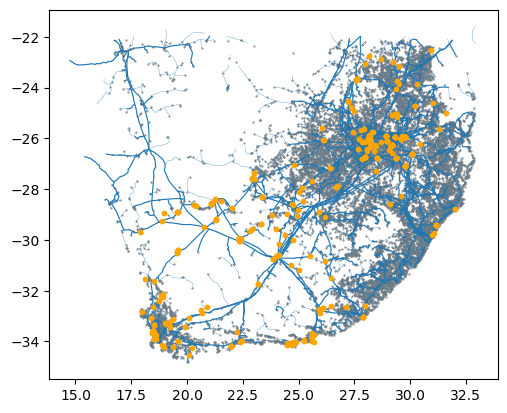

In [66]:
fig, ax = plt.subplots()
network.edges.query("line_voltage_class == 'medium'").plot(ax=ax, linewidth=0.2, zorder=2)
network.edges.query("line_voltage_class == 'high'").plot(ax=ax, linewidth=0.8, zorder=3)
network.nodes.query("asset_type == 'demand'").plot(ax=ax, marker=".", markersize=1, color="grey", zorder=1)
network.nodes.query("asset_type == 'generation'").plot(ax=ax, marker="o", markersize=10, color="orange", zorder=4)

In [67]:
network = snkit.network.split_multilinestrings(network)

In [ ]:
geod = Geod(ellps="WGS84")
edge_limit = 20_000 # meters

# Connect generation
network = snkit.network.link_nodes_to_nearest_edge(
    network,
    lambda node, edge: node.asset_type == 'generation' and geod.geometry_length(edge.geometry) < edge_limit
)

network.nodes.loc[network.nodes.asset_type.isnull(), 'asset_type'] = 'conn_source'

# Connect demand
network = snkit.network.link_nodes_to_nearest_edge(
    network,
    lambda node, edge: node.asset_type == 'demand' and geod.geometry_length(edge.geometry) < edge_limit
)
network.nodes.loc[network.nodes.asset_type.isnull(), 'asset_type'] = 'conn_target'

# Add nodes at line endpoints
network = snkit.network.add_endpoints(network)
network.nodes.loc[network.nodes.asset_type.isnull(), 'asset_type'] = 'intermediate'

# add from/to ids
network = snkit.network.add_topology(snkit.network.add_ids(network))

In [74]:
network_path = processed_data_path / "networks" / "power" / "power_network.2025-05-01.gpkg"
network_path.parent.mkdir(exist_ok=True, parents=True)
network.set_crs("EPSG:4326")
network.to_file(network_path, nodes_layer="power_nodes", edges_layer="power_edges")